## Cloning the repository

In [ ]:

!git clone https://github.com/badhri123/Visualizing-GANs.git


Cloning into 'Visualizing-GANs'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 60 (delta 25), reused 34 (delta 12), pack-reused 0
Unpacking objects: 100% (60/60), done.


## Installing required packages

In [ ]:
!pip install -r /content/Visualizing-GANs/requirements.txt

     |████████████████████████████████| 112kB 21.6MB/s 
     |████████████████████████████████| 163kB 32.2MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 3.0MB 53.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 307kB 54.0MB/s 
     |████████████████████████████████| 92kB 13.7MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 14.6MB 179kB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 1.3MB 53.8MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 6.9MB 49.5MB/s 
     |████████████████████████████████| 3.0MB 59.2MB/s 
     |████████████████████████████████| 778kB 49.8MB/s 
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 53.4MB/s 
     |████████████████████████████████| 133kB 58.1MB/s 


##GAN Training - Network (MNIST)

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

loss_generator_track =[]
loss_discriminator_track=[]
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        print(img.shape)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Dense(28 * 28 * 64, input_shape =[100],activation='relu'))
      model.add(tf.keras.layers.Reshape([28, 28, 64]))
      # model.add(tf.keras.layers.BatchNormalization()) 
      model.add(tf.keras.layers.Conv2D( 128, (3, 3), (1, 1), padding ="same", activation ="selu"))
      # model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Conv2D( 128, (3, 3), (1, 1), padding ="same", activation ="selu"))
      # model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Conv2D( 1, (3, 3), (1, 1), padding ="same", activation ="sigmoid"))
  
    
      model.summary()

      noise = Input(shape=(self.latent_dim,))
      img = model(noise)
      return Model(noise, img)

    def build_discriminator(self):

      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]))
      model.add(tf.keras.layers.LeakyReLU(0.2))
      model.add(tf.keras.layers.Dropout(0.3))
      model.add(tf.keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"))
      model.add(tf.keras.layers.LeakyReLU(0.2))
      model.add(tf.keras.layers.Dropout(0.3))
      model.add(tf.keras.layers.Flatten())
      model.add(tf.keras.layers.Dense(1, activation ='sigmoid') )
      model.summary()
      img = Input(shape=self.img_shape)
      validity = model(img)

      return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = mnist.load_data()
        X_train = (X_train/255)
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            loss_generator_track.append(g_loss)
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            loss_discriminator_track.append(d_loss)
            print(epoch,g_loss )

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        # fig.savefig("images/%d.png" % epoch)
        plt.close()

gan = GAN()
gan.train(epochs=10000,batch_size=128, sample_interval=100)

## Generated Images 

In [ ]:
from scipy import io
noise = np.random.normal(0, 1, (16, 100))
valid = np.ones((16, 1))
g_loss = gan.combined.train_on_batch(noise, valid)
gen_imgs = gan.generator.predict(noise)

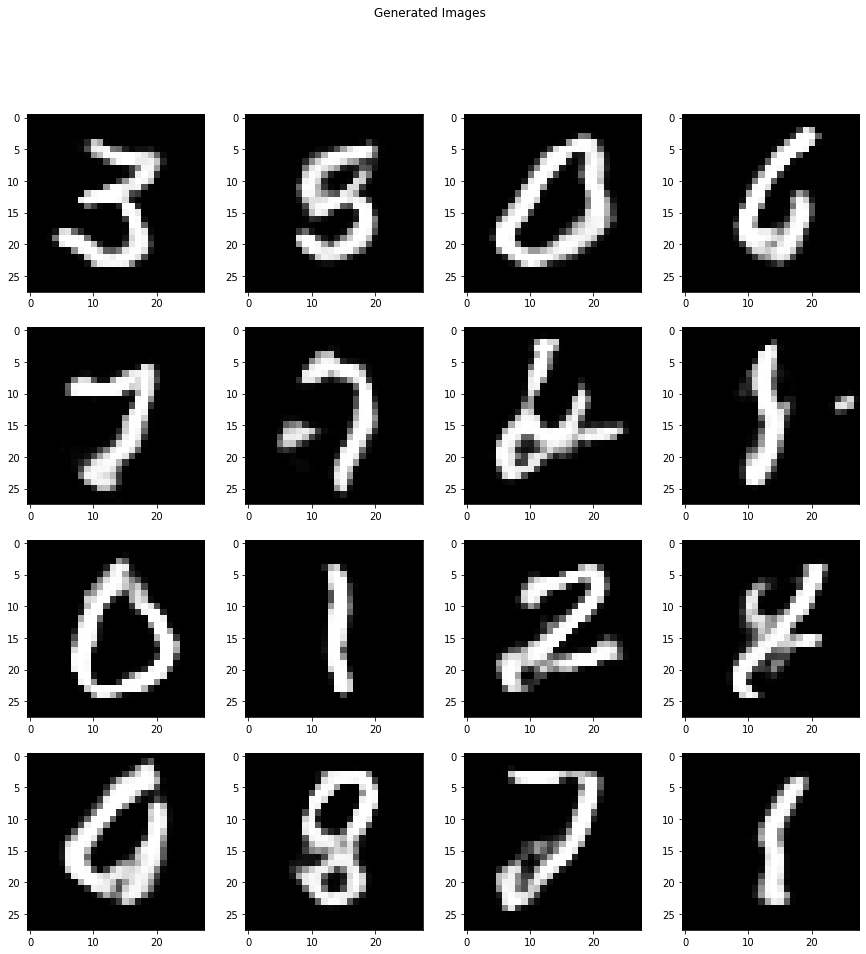

In [ ]:
fig, axs = plt.subplots(4,4)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('Generated Images')
k=0
for i in range(4):
  for j in range(4):
  
    axs[i][j].imshow(gen_imgs[k].reshape(28,28),cmap='gray')
    k=k+1

## Loss Curves

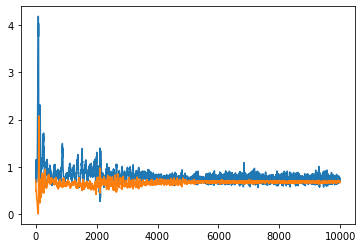

In [ ]:
plt.figure()
plt.plot(loss_generator_track)
# plt.show()
# plt.clf()
# plt.cla()
# plt.close()
# plt.figure()
l = [i[0] for i in loss_discriminator_track]

plt.plot(l)
plt.show()
plt.clf()
plt.cla()
plt.close()

In [ ]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/Visualizing-GANs/landscapeviz')

import utils
from utils import build_mesh
from visualizer import plot_contour,plot_3d

## Generator Loss Landscape

In [ ]:

noise_input = np.random.normal(0, 1, (1000, 100))
y_use = np.ones((1000,))

In [ ]:
total = len(gan.combined.get_weights())
disc = len(gan.discriminator.get_weights())
mask = np.ones((total,))
mask[-disc:] = np.zeros(disc,)

conv_transpose_list =[]


build_mesh(gan.combined, (noise_input, y_use), grid_length=30, extension=4,verbose=1,use_mask=True,mask=mask,weight_type_mask=conv_transpose_list)
# build_mesh(gan.discriminator, (X_final, y_final), grid_length=20, verbose=1,use_mask=False)

# build_mesh(model, (input_train, target_train), grid_length=40, verbose=1)


(100, 50176)
(50176,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 1)
(1,)
(5, 5, 1, 64)
(64,)
(5, 5, 64, 128)
(128,)
(6272, 1)
(1,)


INFO:root:line 0 out of 30
INFO:root:line 1 out of 30
INFO:root:line 2 out of 30
INFO:root:line 3 out of 30
INFO:root:line 4 out of 30
INFO:root:line 5 out of 30
INFO:root:line 6 out of 30
INFO:root:line 7 out of 30
INFO:root:line 8 out of 30
INFO:root:line 9 out of 30
INFO:root:line 10 out of 30
INFO:root:line 11 out of 30
INFO:root:line 12 out of 30
INFO:root:line 13 out of 30
INFO:root:line 14 out of 30
INFO:root:line 15 out of 30
INFO:root:line 16 out of 30
INFO:root:line 17 out of 30
INFO:root:line 18 out of 30
INFO:root:line 19 out of 30
INFO:root:line 20 out of 30
INFO:root:line 21 out of 30
INFO:root:line 22 out of 30
INFO:root:line 23 out of 30
INFO:root:line 24 out of 30
INFO:root:line 25 out of 30
INFO:root:line 26 out of 30
INFO:root:line 27 out of 30
INFO:root:line 28 out of 30
INFO:root:line 29 out of 30


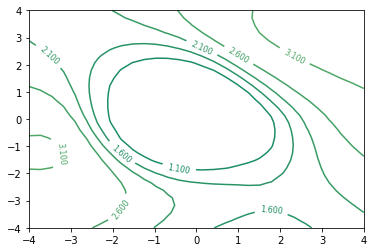

(30, 30)


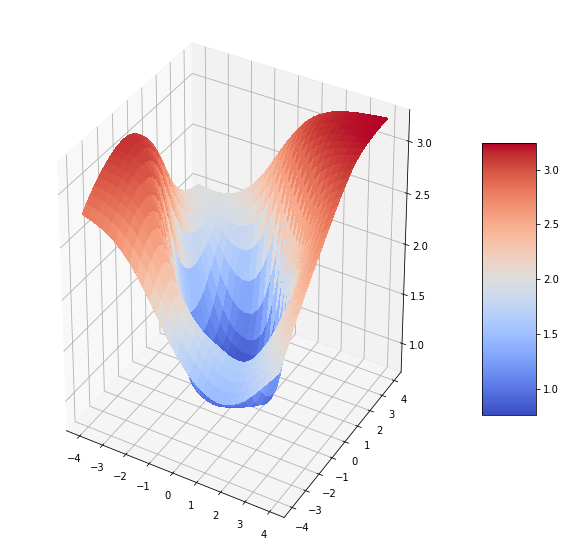

In [ ]:
 # %matplotlib inline
import math
from tensorflow.keras.losses import sparse_categorical_crossentropy
plot_contour(key="binary_crossentropy")
x,y,z = plot_3d(key="binary_crossentropy")



In [ ]:
data={'X':x, 'Y':y,'Z':z}
io.savemat('generator_1_out_no_batchnorm.mat',data)

## Discriminator Loss Landscape

In [ ]:
noise = np.random.normal(0, 1, (50000,100))
gen_imgs = gan.generator.predict(noise)
gen_labels = np.zeros((50000,))
print(gen_imgs.shape)
print(gen_labels.shape)


(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train) /255
X_train = np.expand_dims(X_train, axis=3)
X_train_half = X_train[:50000,:,:,:]
y_train_half = np.ones((50000,))
print(X_train_half.shape)
X_train_half = X_train_half.reshape((-1,28,28,1))
print(y_train_half.shape)

X_final = np.concatenate((gen_imgs,X_train_half),axis=0)
y_final = np.concatenate((gen_labels,y_train_half))
print(X_final.shape,y_final.shape)
from sklearn.model_selection import train_test_split

X_train, X_use, y_train, y_use = train_test_split(X_final, y_final, test_size=0.01, random_state=42)


print(X_use.shape)
del X_train, y_train, gen_imgs,noise

(50000, 28, 28, 1)
(50000,)
(50000, 28, 28, 1)
(50000,)
(100000, 28, 28, 1) (100000,)
(1000, 28, 28, 1)


In [ ]:
# noise_input = np.random.normal(0, 1, (10000, 100))
# y_use = np.zeros((10000,))
# gen_im = gan.generator(noise_input)
build_mesh(gan.discriminator, (X_use, y_use),extension=4, grid_length=30, verbose=1)


INFO:root:line 0 out of 30


(5, 5, 1, 64)
(64,)
(5, 5, 64, 128)
(128,)
(6272, 1)
(1,)


INFO:root:line 1 out of 30
INFO:root:line 2 out of 30
INFO:root:line 3 out of 30
INFO:root:line 4 out of 30
INFO:root:line 5 out of 30
INFO:root:line 6 out of 30
INFO:root:line 7 out of 30
INFO:root:line 8 out of 30
INFO:root:line 9 out of 30
INFO:root:line 10 out of 30
INFO:root:line 11 out of 30
INFO:root:line 12 out of 30
INFO:root:line 13 out of 30
INFO:root:line 14 out of 30
INFO:root:line 15 out of 30
INFO:root:line 16 out of 30
INFO:root:line 17 out of 30
INFO:root:line 18 out of 30
INFO:root:line 19 out of 30
INFO:root:line 20 out of 30
INFO:root:line 21 out of 30
INFO:root:line 22 out of 30
INFO:root:line 23 out of 30
INFO:root:line 24 out of 30
INFO:root:line 25 out of 30
INFO:root:line 26 out of 30
INFO:root:line 27 out of 30
INFO:root:line 28 out of 30
INFO:root:line 29 out of 30


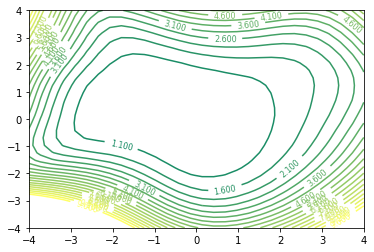

(30, 30)


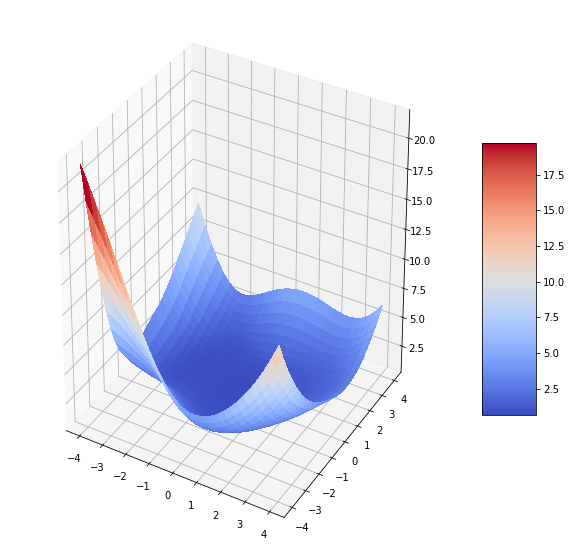

In [ ]:
# !pip install PyQt5
# import PyQt5
# %matplotlib 

from tensorflow.keras.losses import sparse_categorical_crossentropy
plot_contour(key="binary_crossentropy")
X,Y,Z = plot_3d(key="binary_crossentropy")



In [ ]:
data={'X':X, 'Y':Y,'Z':Z}
io.savemat('discriminator_2_no_batchnorm.mat',data)